# Collaborative Filtering Neaural Network

In [166]:
## data
import numpy as np
import pandas as pd
from datetime import datetime

## visualisation
import matplotlib.pyplot as plt
import seaborn as sns

## ML
from sklearn import metrics, preprocessing

## deep learning
from tensorflow.keras import models, layers, utils  


# Loading Data

In [167]:
## load movies data
movies = pd.read_csv("data/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [168]:
## load user ratings data
users = pd.read_csv("data/ratings.csv")
users.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# Data Cleaning

In [169]:
## Movies

## assign new movie id to "movie"
movies["movie"] = range(0,len(movies))

## extract the movie's name from the "title" column
movies["name"] = movies["title"].str.split(r"(").str[0]

## extract the movie's year from the "title" column
movies["year"] = movies["title"].apply(lambda x: int(x.split(r"(")[-1][0:4]) if r"(" in x else np.nan)

## new feature: "old" is True if year is < 2000, o/w False
movies["old"] = movies["year"].apply(lambda x: 1 if x < 2000 else 0)
movies.head()

,movieId,title,genres,movie,name,year,old
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,Toy Story,1995.0,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,Jumanji,1995.0,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2,Grumpier Old Men,1995.0,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,Waiting to Exhale,1995.0,1
4,5,Father of the Bride Part II (1995),Comedy,4,Father of the Bride Part II,1995.0,1


In [170]:
## Users

## scale new user id starting at 0 and assign to "user"
users["user"] = users["userId"].apply(lambda x: x-1)

## converting timestamp int into Timestamp
users["timestamp"] = users["timestamp"].apply(lambda x: datetime.fromtimestamp(x))

## flagging if timestamp is during the daytime
users["daytime"] = users["timestamp"].apply(lambda x: 1 if 6<int(x.strftime("%H"))<20 else 0)

## flagging if timestamp is on the weekend
users["weekend"] = users["timestamp"].apply(lambda x: 1 if x.weekday() in [5,6] else 0)

## adding new movie id column "movie" to users df
users = users.merge(movies[["movieId","movie"]], how="left")

## rename "rating" to "y" (this is our target variable)
users = users.rename(columns={"rating":"y"})
users.head()

,userId,movieId,y,timestamp,user,daytime,weekend,movie
0,1,1,4.0,2000-07-30 11:45:03,0,1,1,0
1,1,3,4.0,2000-07-30 11:20:47,0,1,1,2
2,1,6,4.0,2000-07-30 11:37:04,0,1,1,5
3,1,47,5.0,2000-07-30 12:03:35,0,1,1,43
4,1,50,5.0,2000-07-30 11:48:51,0,1,1,46


In [171]:
## clean movies
movies = movies[["movie","name","old","genres"]].set_index("movie")
movies.head()

,name,old,genres
movie,,,
0,Toy Story,1,Adventure|Animation|Children|Comedy|Fantasy
1,Jumanji,1,Adventure|Children|Fantasy
2,Grumpier Old Men,1,Comedy|Romance
3,Waiting to Exhale,1,Comedy|Drama|Romance
4,Father of the Bride Part II,1,Comedy


In [172]:
## clean users
users = users[["user","movie","daytime","weekend","y"]]
users.head()

,user,movie,daytime,weekend,y
0,0,0,1,1,4.0
1,0,2,1,1,4.0
2,0,5,1,1,4.0
3,0,43,1,1,5.0
4,0,46,1,1,5.0


In [173]:
## saving other features into context if needed later
context = users[["user","movie","daytime","weekend"]]
context.head()

,user,movie,daytime,weekend
0,0,0,1,1
1,0,2,1,1
2,0,5,1,1
3,0,43,1,1
4,0,46,1,1


In [174]:
## Create Movies x Features dataframe
movies_features = pd.DataFrame({"old":movies["old"]})


## One-Hot-Encode genres
genres = list(movies["genres"].str.split(r"|"))
temp = genres[0]
for i in range(1, len(genres)):
    temp.extend(genres[i])

new_cols = list(set(temp))
new_cols.remove("(no genres listed)")
for col in new_cols:
    movies_features[col] = movies["genres"].str.contains(col).astype(int)
movies_features.head()

,old,War,Musical,IMAX,Animation,Romance,Documentary,Drama,Crime,Children,Fantasy,Thriller,Sci-Fi,Western,Adventure,Mystery,Comedy,Action,Horror,Film-Noir
movie,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [175]:
## Create Users x Movies dataframe
users_tmp = users.copy()
users_movies = users_tmp.pivot(index="user", columns="movie", values="y")

missing_cols = list(set(movies.index) - set(users_movies.columns))
for col in missing_cols:
    users_movies[col] = np.nan
users_movies = users_movies[sorted(users_movies.columns)]

## scale all ratings between 0.5 and 1
users_movies = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(users_movies.values), columns=users_movies.columns, index=users_movies.index)
users_movies

/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


movie,0,1,2,3,4,5,6,7,8,9,...,9732,9733,9734,9735,9736,9737,9738,9739,9740,9741
user,,,,,,,,,,,,,,,,,,,,,
0,0.888889,NaN,0.888889,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.722222,NaN,NaN,NaN,NaN,NaN,0.6875,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,0.722222,0.666667,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,0.888889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Understanding the Data

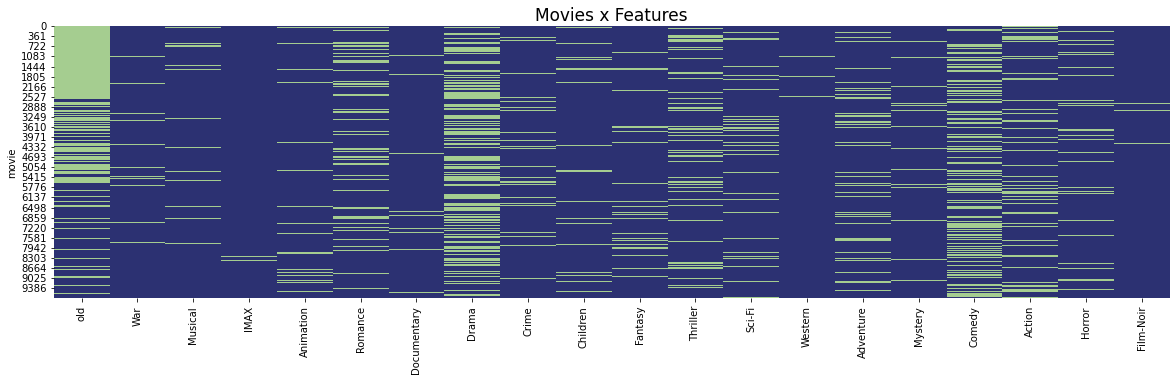

In [176]:
## heatmap: Movies x Features
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(movies_features==0, vmin=0, vmax=1, cbar=False, cmap='crest', ax=ax).set_title("Movies x Features", size=17)
plt.show()

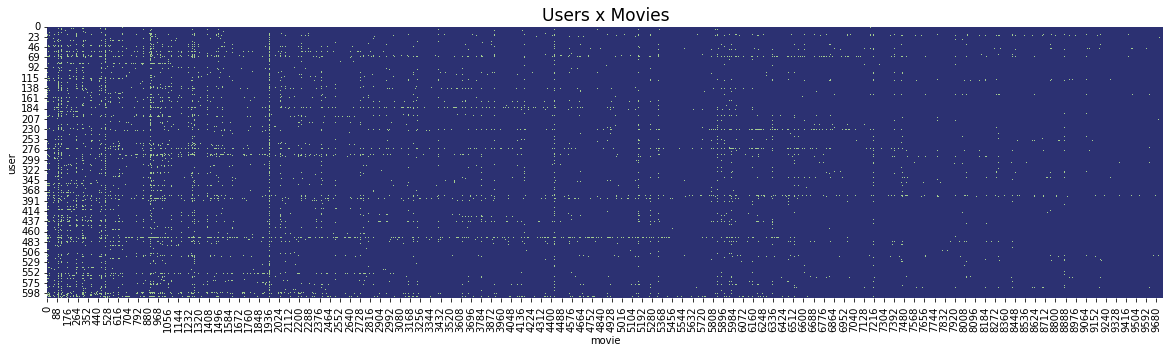

In [177]:
## heatmap: Users X Movies
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(users_movies.isnull(), vmin=0, vmax=1, cbar=False, cmap='crest', ax=ax).set_title("Users x Movies", size=17)
plt.show()

# Train and Test Split

In [178]:
## Represent all users in both train and test dataframes
## Include 80% of movies in train dataframe and 20% in test dataframe

## split users x movies df vertically at 80/20 split
split = int(0.8*users_movies.shape[1])
users_movies_train = users_movies.loc[:, :split-1]
users_movies_test = users_movies.loc[:, split:]
print("---Train and Test Shapes---")
print("Users x Movies Train: ", users_movies_train.shape)
print("Users x Movies Test: ", users_movies_test.shape)

# ## split movies x features df horizontally at 80/20 split 
# split = int(0.8*users_movies.shape[1])
# movies_features_train = movies_features.loc[:split-1, :]
# movies_features_test = movies_features.loc[split:, :]

# print("Movies x Features Train: ", movies_features_train.shape)
# print("Movies x Features Test: ", movies_features_test.shape)

---Train and Test Shapes---
Users x Movies Train:  (610, 7793)
Users x Movies Test:  (610, 1949)


In [179]:
train = users_movies_train.stack(dropna=True).reset_index().rename(columns={0:"y"})
train.head()

,user,movie,y
0,0,0,0.888889
1,0,2,0.888889
2,0,5,0.875000
3,0,43,1.000000
4,0,46,1.000000


In [180]:
test = users_movies_test.stack(dropna=True).reset_index().rename(columns={0:"y"})
test

,user,movie,y
0,1,8063,0.812500
1,1,8305,1.000000
2,1,8376,0.777778
3,1,8466,0.875000
4,1,8509,0.500000
...,...,...,...
6777,609,9434,0.937500
6778,609,9461,1.000000
6779,609,9462,1.000000
6780,609,9463,1.000000


In [181]:
embeddings_size = 50
usr, prd = users_movies.shape[0], users_movies.shape[1]


## Query
## instantiate user input keras tensor
xusers_in = layers.Input(name="xusers_in", shape=(1,))
## convert user integers to embedding of fixed size (, 1, embedding_size)
xusers_emb = layers.Embedding(name="xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
## reshape to (, embedding_size)
xusers = layers.Reshape(name='xusers', target_shape=(embeddings_size,))(xusers_emb)

## Candidate
## instantiate movie input keras tensor
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))
## convert movie integers to embedding of fixed size (, 1, embedding_size)
xproducts_emb = layers.Embedding(name="xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
## reshape to (, embedding_size)
xproducts = layers.Reshape(name='xproducts', target_shape=(embeddings_size,))(xproducts_emb)

# Product (,1) values[-1,1]
xx = layers.Dot(name='xx', normalize=True, axes=1)([xusers, xproducts])

# Predict ratings (,1)
y_out = layers.Dense(name="y_out", units=1, activation='linear')(xx)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xusers_in (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 xproducts_in (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 xusers_emb (Embedding)         (None, 1, 50)        30500       ['xusers_in[0][0]']              
                                                                                                  
 xproducts_emb (Embedding)      (None, 1, 50)        487100      ['xproducts_in[0][0]']           
                                                                             

In [182]:
# utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [193]:
'''
Plot loss and metrics of keras training.
'''
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

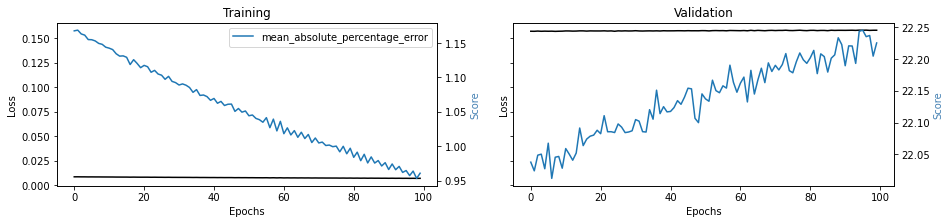

In [194]:
# Train
training = model.fit(x=[train["user"], train["movie"]], y=train["y"], epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
utils_plot_keras_training(training)


In [195]:
# Test
test["yhat"] = model.predict([test["user"], test["movie"]])
test

212/212 [==============================] - 0s 788us/step


,user,movie,y,yhat
0,1,8063,0.812500,0.713988
1,1,8305,1.000000,0.996647
2,1,8376,0.777778,0.726962
3,1,8466,0.875000,0.791335
4,1,8509,0.500000,0.640731
...,...,...,...,...
6777,609,9434,0.937500,0.699522
6778,609,9461,1.000000,0.645040
6779,609,9462,1.000000,0.824654
6780,609,9463,1.000000,0.859342


In [186]:
# overall
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

Mean Absolute Error (Σ|y-pred|/n): 0
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.24%


In [187]:
# Evaluate
def mean_reciprocal_rank(y_test, predicted):
    score = []
    for product in y_test:
        mrr = 1 / (list(predicted).index(product) + 1) if product in predicted else 0
        score.append(mrr)
    return np.mean(score)

In [188]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["movie"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["movie"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8466 8550 8063]
predicted: [8305 8550 8681 8466 8828]
true positive: 4 (80.0%)
accuracy: 20.0%
mrr: 0.42


In [189]:
## averages for all users

true_positives = []
accuracy = []
mrr = []

for i in np.unique(test["user"]):
    top = 5
    y_test = test[test["user"]==i].sort_values("y", ascending=False)["movie"].values[:top]
    predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["movie"].values[:top]
    true_positive = len(list(set(y_test) & set(predicted)))
    true_positives.append(true_positive)
    accuracy.append(metrics.accuracy_score(y_test,predicted))
    mrr.append(mean_reciprocal_rank(y_test, predicted))

    
print("--- evaluation of test users' top 5 predicted movies ---")
print("avg true positive:", np.mean(true_positives), "("+str(round(np.mean(true_positives)/top*100,1))+"%)")
print("avg accuracy:", str(round(np.mean(accuracy)*100,1))+"%")
print("avg mrr:", round(np.mean(mrr),2))    

--- evaluation of test users' top 5 predicted movies ---
avg true positive: 2.0 (40.0%)
avg accuracy: 17.5%
avg mrr: 0.31


In [190]:
test[test["user"]==i].merge(
        movies[["name","old","genres"]], left_on="movie", right_index=True
    ).sort_values("yhat", ascending=False)

,user,movie,y,yhat,name,old,genres
6569,609,8174,0.500000,1.009338,"Lords of Salem, The",0,Horror|Thriller
6567,609,8166,1.000000,1.008366,Fast & Furious 6,0,Action|Crime|Thriller|IMAX
6501,609,7888,0.785714,0.981655,Prometheus,0,Action|Horror|Sci-Fi|IMAX
6620,609,8379,0.875000,0.981190,Non-Stop,0,Action|Mystery|Thriller
6638,609,8450,0.800000,0.980750,"Equalizer, The",0,Action|Crime|Thriller
...,...,...,...,...,...,...,...
6749,609,9162,0.800000,0.555430,"Big Short, The",0,Drama
6739,609,9077,0.500000,0.548817,Last Shift,0,Horror
6565,609,8156,0.500000,0.545316,Shaolin Temple,1,Action|Adventure|Drama
6773,609,9389,0.500000,0.541777,Blair Witch,0,Horror|Thriller
